# ABS Population Growth multi-measure

## Python set-up

In [1]:
# system imports
from pathlib import Path

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import numpy as np

In [2]:
# local imports
from plotting  import line_plot, clear_chart_dir, set_chart_dir
from readabs import read_abs_series, recalibrate, qtly_to_monthly

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
CHART_DIR = "./CHARTS/Population/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
SHOW = True

## Download data from the ABS

In [4]:
def compile_data() -> tuple[DataFrame, DataFrame, DataFrame, str]:
    """compile comparative population information"""

    # identify the data we need to download
    erp = {
        "A2133251W": "Official Estimated Resident Population (ERP)",
        "A2133255F": "ERP Change Over Previous Year",
        "A2133256J": "Percentage ERP Change Over Previous Year",
    }
    civ = {
        "A84423091W": "Civilian population aged 15 years and over",
    }
    gdp = {
        "A2302460K": "GDP per capita: Chain volume measures (Orig)",
        "A2302459A": "Gross domestic product: Chain volume measures (Orig)"
    }
    mig = {
        "A85232568L": "Number of movements ; Permanent and Long-term arrivals",
        "A85232558J": "Number of movements ; Permanent and Long-term departures",
    }

    # download relevant data from the ABS
    erp_data, erp_meta = read_abs_series("3101.0", erp, single_excel_only="310101")
    civilian_data, civilian_meta = read_abs_series("6202.0", civ, single_excel_only="6202001")
    gdp_data, gdp_meta = read_abs_series("5206.0", gdp, single_excel_only="5206001_Key_Aggregates")
    mig_data, mig_meta = read_abs_series("3401.0", mig)

    # reconstruct a population estimateb from the national accounts ('000 persons)
    gdp_implicit_pop = gdp_data["A2302459A"] / gdp_data["A2302460K"] * 1_000

    # reconstruct 12mon sum of Permanent and Long-term net migration ('000 persons)
    mig_data = mig_data.rolling(window=12, min_periods=12).sum()
    rolling_net_migration = (mig_data["A85232568L"] - mig_data["A85232558J"]) / 1_000
    rolling_net_migration.name = "12m rolling sum of net permanent and long-term migration"

    # convert all data to monthly and rename
    erp_data = qtly_to_monthly(erp_data, interpolate=False)
    erp_data = (
        erp_data.rename(columns=erp)
        .reindex(pd.period_range(erp_data.index[0], erp_data.index[-1], freq="M"), fill_value=np.nan)
    )
    gdp_implicit_pop = qtly_to_monthly(gdp_implicit_pop, interpolate=False)
    gdp_implicit_pop = (
        gdp_implicit_pop.reindex(
            pd.period_range(gdp_implicit_pop.index[0], gdp_implicit_pop.index[-1], freq="M"), fill_value=np.nan
        )
    )
    gdp_implicit_pop.name = "Implicit population in National Accounts"
    civilian_data = civilian_data.rename(columns=civ)

    # merge the data into three dataframes
    population = pd.concat([gdp_implicit_pop, 
                            erp_data["Official Estimated Resident Population (ERP)"], 
                            civilian_data], axis=1).sort_index()

    pop_growth_n = pd.concat([
        gdp_implicit_pop.diff(12),
        erp_data["ERP Change Over Previous Year"],
        civilian_data.diff(12),
        rolling_net_migration], axis=1).sort_index()
    
    pop_growth_pct = pd.concat([
        gdp_implicit_pop.pct_change(12, fill_method=None) * 100,
        erp_data["Percentage ERP Change Over Previous Year"],
        civilian_data.pct_change(12, fill_method=None) * 100], axis=1).sort_index()   

    source = f"ABS: {', '.join(sorted(["3101.0", "6202.0", "5206.0", "3401.0"]))}"
    return population, pop_growth_n, pop_growth_pct, source


population, pop_growth_n, pop_growth_pct, source = compile_data()

Caution: Could not find the 'Index' sheet in 3401013. File not included
Caution: Could not find the 'Index' sheet in 3401014. File not included
Caution: Could not find the 'Index' sheet in 3401015. File not included
Caution: Could not find the 'Index' sheet in 3401016. File not included
Caution: Could not find the 'Index' sheet in 3401017. File not included


## Plot

In [5]:
RECENT = 63  # months

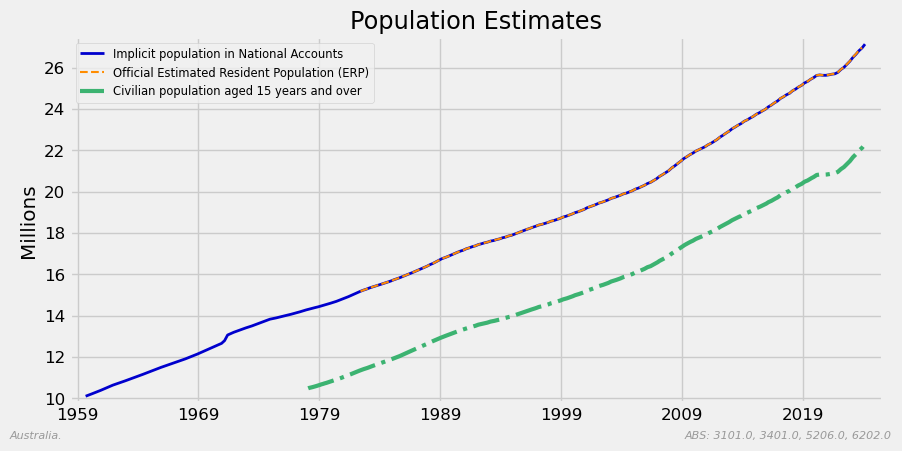

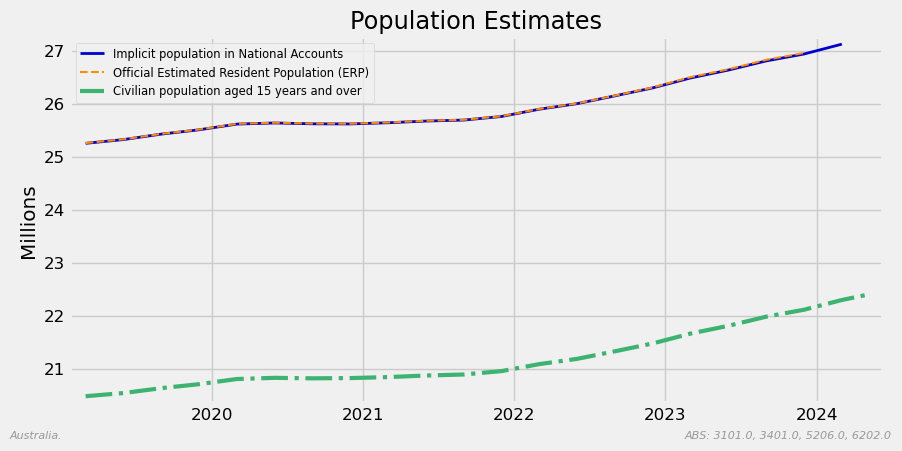

In [6]:
population_r, units = recalibrate(population, "Thousands")
line_plot(
    population_r,
    starts=(None, population_r.index[-RECENT]),
    title="Population Estimates",
    ylabel=units,
    dropna=True,
    width=[2, 1.5, 3],
    style=["-", "--", "-."],
    lfooter="Australia. ",
    rfooter=source,
    show=SHOW,
)

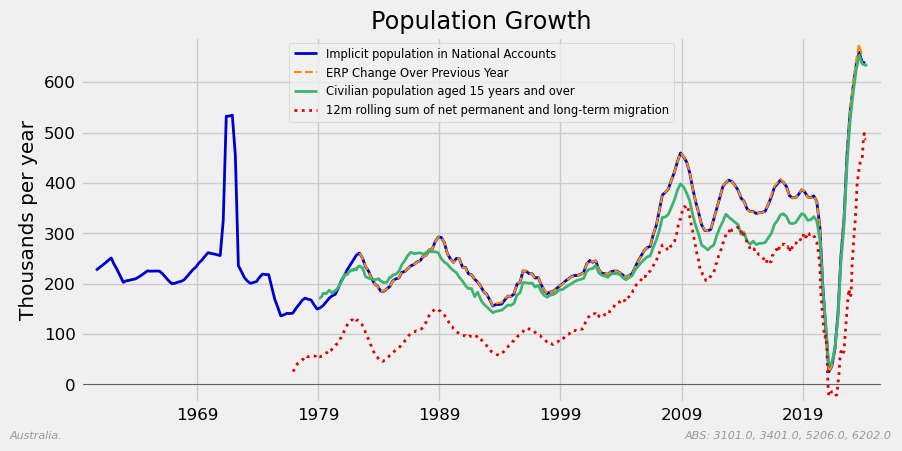

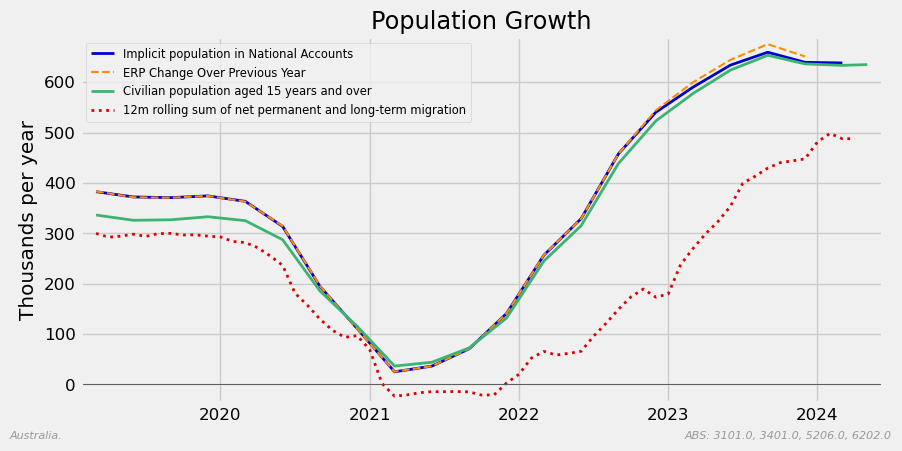

In [7]:
line_plot(
    pop_growth_n,
    title="Population Growth",
    starts=(None, pop_growth_n.index[-RECENT]),
    ylabel="Thousands per year",
    dropna=True,
    width=[2, 1.5, 2],
    style=["-", "--", "-", ":"],
    y0=True,
    lfooter="Australia. ",
    rfooter=source,
    show=SHOW,
)


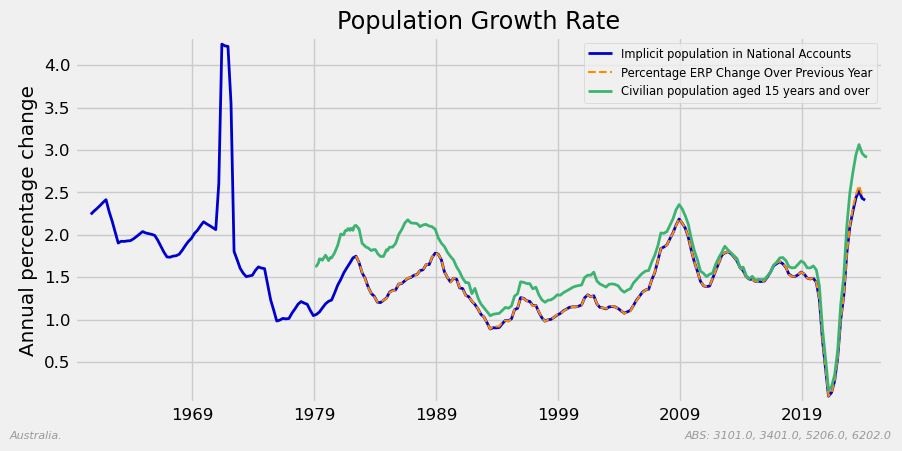

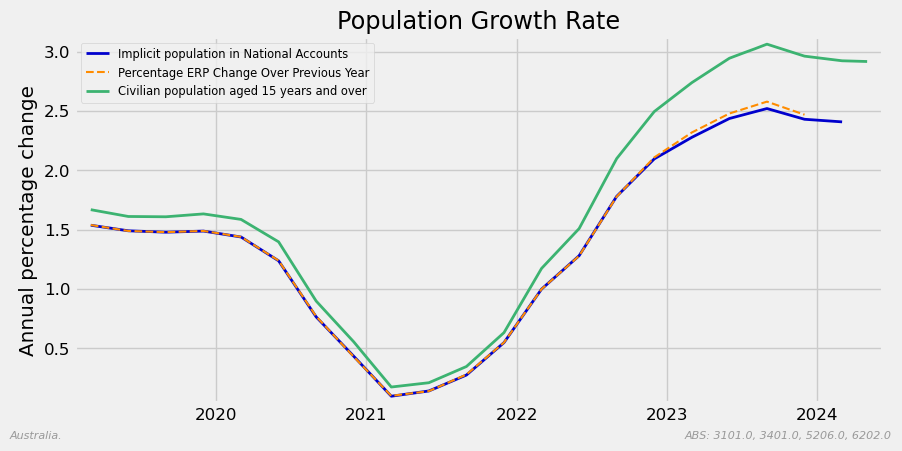

In [8]:
line_plot(
    pop_growth_pct,
    title="Population Growth Rate",
    starts=(None, pop_growth_pct.index[-RECENT]),
    ylabel="Annual percentage change",
    dropna=True,
    width=[2, 1.5, 2],
    style=["-", "--", "-", ":"],
    y0=True,
    lfooter="Australia. ",
    rfooter=source,
    show=SHOW,
)

## Finished

In [9]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Jun 28 2024 11:41:17

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.8.4

Watermark: 2.4.3



In [10]:
print("Finished")

Finished
